# Семинар 14: калибровка моделей

## Вступление

Разговор о калибровке — это разговор о том, как оценивать вероятности классов хорошо и правильно. Она необходима в тех случаях, когда итоговое решение существенным образом зависит от вероятностей.

Например:
- Выдать ли заемщику кредит? (зависит от вероятности дефолта заемщика)
- Стоит ли принимать клиента на страхование? (зависит от вероятности наступления страхового случая)
- Подсчет ожидаемой доходности на клиенте: <br>
  Если $f(x)$ — маржа, которую мы получим в случае покупки клиентом продукта, а $p(x)$ — вероятность того, что клиент купит продукт в случае, если мы ему позвоним, тогда пусть $\hat{f}(x)$ — это откалиброванная вероятность $p(x)$. В таком случае, в первую очередь нам стоит звонить клиентам с максимальным $\hat{f}(x)$
  
Кроме того, вероятности могут пригодиться для интерпретации модели и комплексной оценки качества с повышенной уверенностью. Наконец, в более сложных пайплайнах вероятности могут иметь прямое влияние на последующие алгоритмы, использующие выход модели. Можно сказать, что калибровка не так важна, если нас интересует лишь лучший ответ, т.е. достаточно жесткой классификации.

### План семинара <a class="anchor" id="menu"></a>
В калибровке можно выделить две составные части:
    
* [Оценка степени откалиброванности имеющейся модели](#chapter1)
* [Собственно, калибровка как увеличение степени откалиброванности модели](#chapter2)

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

warnings.filterwarnings("ignore")

%matplotlib inline

### 0. Обучение исходных моделей

Рассматривать вопросы калибровки (как оценки, так и улучшения) будем на примере хорошо известной нам задачи кредитного скоринга с бинарной классификацией. Загрузим датасет и предобработаем данные:

In [ ]:
dataset = pd.read_csv(
    "https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw03-EDA-data/german_credit.csv"
)
dataset.head(3)

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,no checking account,18,all credits at this bank paid back duly,car (used),1049,unknown/no savings account,< 1 yr,< 20,female : non-single or male : single,none,...,car or other,21,none,for free,1,skilled employee/official,0 to 2,no,no,good
1,no checking account,9,all credits at this bank paid back duly,others,2799,unknown/no savings account,1 <= ... < 4 yrs,25 <= ... < 35,male : married/widowed,none,...,unknown / no property,36,none,for free,2-3,skilled employee/official,3 or more,no,no,good
2,... < 0 DM,12,no credits taken/all credits paid back duly,retraining,841,... < 100 DM,4 <= ... < 7 yrs,25 <= ... < 35,female : non-single or male : single,none,...,unknown / no property,23,none,for free,1,unskilled - resident,0 to 2,no,no,good


In [ ]:
for x in dataset.columns:
    if dataset[x].dtype == "object":
        dataset[x] = LabelEncoder().fit_transform(dataset[x])

dataset["age"] = pd.cut(dataset.age, (18, 25, 35, 50, 65, 80), labels=[0, 1, 2, 3, 4])

dataset["amount"] = pd.cut(
    dataset.amount, (250, 1000, 2000, 4000, 8000, 20000), labels=[0, 1, 2, 3, 4]
)

dataset["duration"] = pd.cut(
    dataset.duration, (4, 6, 8, 12, 18, 24, 36, 48, 72), labels=[0, 1, 2, 3, 4, 5, 6, 7]
)

dataset.head(3)

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,3,3,0,2,1,4,2,2,0,2,...,1,0,1,0,0,1,0,0,0,1
1,3,2,0,5,2,4,0,1,3,2,...,3,2,1,0,1,1,1,0,0,1
2,0,2,4,8,0,0,1,1,0,2,...,3,0,1,0,0,3,0,0,0,1


In [ ]:
dataset.columns

Index(['status', 'duration', 'credit_history', 'purpose', 'amount', 'savings',
       'employment_duration', 'installment_rate', 'personal_status_sex',
       'other_debtors', 'present_residence', 'property', 'age',
       'other_installment_plans', 'housing', 'number_credits', 'job',
       'people_liable', 'telephone', 'foreign_worker', 'credit_risk'],
      dtype='object')

In [ ]:
X = dataset.drop(["credit_risk"], axis=1) # dataset.drop(["credit_risk"], 1)
y = dataset["credit_risk"]

Отбор признаков

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

fs = SelectKBest(score_func=f_classif, k="all")
fs.fit(X, y)

rate = pd.DataFrame(fs.scores_, X.columns, columns=["score"])
rate = rate.sort_values("score", axis=0)
rate

,score
people_liable,0.009071
employment_duration,0.079635
installment_rate,0.126847
present_residence,0.155848
amount,0.428326
other_debtors,0.807899
job,1.071934
telephone,1.328891
number_credits,2.091652
duration,2.588473


In [ ]:
X['status']

,status
0,3
1,3
2,0
3,3
4,3
...,...
995,3
996,3
997,1
998,0


In [ ]:
cols = rate.index.values[::-1]
features = X[[col for col in cols[: len(cols) // 2]]]

In [ ]:
features

,status,housing,savings,age,credit_history,purpose,foreign_worker,personal_status_sex,property,other_installment_plans
0,3,0,4,0,0,2,0,0,1,1
1,3,0,4,2,0,5,0,3,3,1
2,0,0,0,0,4,8,0,0,3,1
3,3,0,4,2,0,5,1,3,3,1
4,3,2,4,2,0,5,1,3,1,0
...,...,...,...,...,...,...,...,...,...,...
995,3,0,4,0,4,4,0,3,3,1
996,3,2,4,2,4,5,0,3,3,1
997,1,1,1,1,0,5,0,3,2,1
998,0,2,1,3,4,4,0,3,2,1


In [ ]:
y.value_counts()

,count
credit_risk,
1,700
0,300


В наших данных имеется некоторый дисбаланс классов, и, вообще говоря, в процессе предобработки неплохо бы его устранить. Сделать это мы можем разными способами. Один из них - синтезировать объекты недостающего класса. Давайте используем для этой цели SMOTE (Synthetic Minority Over-sampling Technique) — пожалуй, наиболее популярный алгоритм из данного семейства.

In [ ]:
# !pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(features.values, y.values)
print("Before SMOTE:")
print(y.value_counts())
print("After SMOTE:")
print(np.unique(y_smote, return_counts=True))

Before SMOTE:
credit_risk
1    700
0    300
Name: count, dtype: int64
After SMOTE:
(array([0, 1]), array([700, 700]))


In [ ]:
pd.Series(y_smote).value_counts()

,count
1,700
0,700


In [ ]:
print("X_smote shape:", X_smote.shape)
print("y_smote shape:", y_smote.shape)

X_smote shape: (1400, 10)
y_smote shape: (1400,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=7
)

#### Logreg

In [ ]:
lr = LogisticRegression(solver="liblinear")
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)
lr_y_pred_proba = lr.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.62      0.68      0.65       136
           1       0.67      0.60      0.64       144

    accuracy                           0.64       280
   macro avg       0.64      0.64      0.64       280
weighted avg       0.65      0.64      0.64       280



#### RBF SVM

In [ ]:
svm_rbf = SVC(kernel="rbf", probability=True)
svm_rbf.fit(X_train, y_train)
svm_rbf_y_pred = svm_rbf.predict(X_test)
svm_rbf_y_pred_proba = svm_rbf.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_test, svm_rbf_y_pred))

              precision    recall  f1-score   support

           0       0.66      0.74      0.70       136
           1       0.72      0.65      0.68       144

    accuracy                           0.69       280
   macro avg       0.69      0.69      0.69       280
weighted avg       0.69      0.69      0.69       280



#### Полиномиальный SVM

In [ ]:
svm_poly = SVC(kernel="poly", degree=8, probability=True)
svm_poly.fit(X_train, y_train)
svm_poly_y_pred = svm_poly.predict(X_test)
svm_poly_y_pred_proba = svm_poly.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_test, svm_poly_y_pred))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       136
           1       0.78      0.73      0.76       144

    accuracy                           0.76       280
   macro avg       0.76      0.76      0.76       280
weighted avg       0.76      0.76      0.76       280



#### kNN

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
svm_poly_y_pred_proba = svm_poly.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77       136
           1       0.81      0.68      0.74       144

    accuracy                           0.75       280
   macro avg       0.76      0.76      0.75       280
weighted avg       0.76      0.75      0.75       280



## 1. Оценка<a class="anchor" id="chapter1"></a>
[К содержанию](#menu)

> Прогнозы откалиброваны, если для некоторого события, вероятность наступления которого была предсказана как X%, реальная частота его наступления действительно составила X%

### 1.1. Оценка при помощи метрик
Вначале обсудим метрики, которые могут указать нам на то, насколько хорошо откалибрована наша модель. В качестве "испытуемой" модели рассмотрим SVM с полиномиальным ядром; чтобы перейти к другим необходимо переопределить y_pred соответствующим образом

In [ ]:
y_pred_proba = svm_poly_y_pred_proba

#### 1.1.1. Лог-лосс

- `log_loss` является хрестоматийной метрикой для измерения того, насколько хорошо предсказанные вероятности соответствуют действительности
- Заметим, что, к примеру, AUC-ROC измеряет качество **ранжирования**, но как таковое ничего не говорит нам о качестве собственно **калибровки**
- `log_loss` дает нам более взвешенное представление как о способности модели строить разделяющую поверхность, так и о качестве ее калибровки
- Сами по себе значения `log_loss` трудно интерпретировать, поэтому используются в основном в сравнении


$\begin{equation}
\mbox{log loss} = \frac{1}{n} \left(\sum_{\mbox{pos cases}} -log(p_i) + \sum_{\mbox{neg cases}} -log(1- p_i)\right)
\end{equation}$

Примеры:

- Если событие предсказано с вероятностью 0.25 и оно произошло, лог-лосс составит $-\log(0.25) = \log(1/0.25) = \log(4)$
- Если событие предсказано с вероятностью 0.80, и оно *не* произошло, лог-лосс составит $-\log(1-0.8) = \log(1/0.2) = \log(5)$
- Лог-лосс равен нулю если мы выдали стопроцентную вероятность события и не прогадали (оно произошло)
- Лог-лосс устремляется в $\infty$ когда мы были на сто процентов уверены в исходе, и оказались неправы


In [ ]:
from sklearn.metrics import log_loss, roc_auc_score

roc_auc_score(y_test, y_pred_proba), log_loss(y_test, y_pred_proba)

(np.float64(0.8171211192810457), 0.6009013585884276)

Если, в качестве примера, мы разделим все вероятности на 4, AUC-ROC не поменяется, но по лог-лоссу мы просядем.

In [ ]:
roc_auc_score(y_test, y_pred_proba / 4), log_loss(y_test, y_pred_proba / 4)

(np.float64(0.8171211192810457), 1.0798425121139623)

#### 1.1.2. Brier Score
$\begin{equation}
\mbox{Brier score} = \frac{1}{n} \sum_{i=1}^n (y_i-p_i)^2
\end{equation}$

Как видно из формулы, можно сказать, что Brier score - это лишь нестандартное название для MSE между предсказанными вероятностями и метками классов. Если предсказанная вероятность составляет 0.7, а метка класса была 1, ошибка на объекте составляет $(1-0.7)^2 = 0.09$. Усредняем по всем объектам, и получаем  Brier score.

Отметим, что Brier score ограничен сверху 1 (худший случай), в то время как лог-лосс может принимать неограниченно большие значения.

In [ ]:
from sklearn.metrics import brier_score_loss

brier_score_loss(y_test, y_pred_proba)

np.float64(0.20675781807946605)

### 1.2. Оценка при помощи диаграммы калибровки (calibration curve)
#### 1.2.1. Теоретический бэкграунд
*Источник: [онлайн-учебник ШАД](https://academy.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti)*

Сформулируем еще раз, что означает, что мы предсказываем корректную вероятность класса 1 (обозначим её $q(x_i)$): это значит, что прогноз «объект $x_i$ принадлежит классу 1 с вероятностью $\frac23$» должен сбываться в $\frac23$ случаев. То есть, условно говоря, если мы возьмём все объекты, которым мы предсказали вероятностью $\frac23$, то среди них что-то около двух третей действительно имеет класс 1. На математическом языке это можно сформулировать так: <strong>Если $\widehat{p}$ – предсказанная вероятность класса 1, то $P(y_i = 1 \vert q(x_i) = \widehat{p}) = \widehat{p}$</strong>.</p><p>В реальной жизни $\widehat{p}$ – это скорее всего вещественные числа, которые будут различными для различных $y_i$, и никаких вероятностей мы не посчитаем, но мы можем разбить отрезок $[0,1]$ на бины, внутри каждого из которых уже вычислить, каковая там доля объектов класса 1, и сравнить эту долю со средним значением вероятности в бине:

<div>
<img src="https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/im_1.png" width="700"/>
</div>

У модели, которая идеально предсказывает вероятности (как обычно говорят, у идеально калиброванной модели) жёлтые точки на диаграме калибровки должны совпадать с розовыми.

А вот на картинке выше это не так: жёлтые точки всегда ниже розовых. Давайте поймём, что это значит. Получается, что наша модель систематически завышает предсказанную вероятность (розовые точки), и порог отсечения нам, выходит, тоже надо было бы сдвинуть вправо:

<div>
<img src="https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/im_2.png" width="700"/>
</div>

Но такая картинка, пожалуй, говорит о какой-то серьёзной патологии классификатора; гораздо чаще встречаются следующие две ситуации:

Слишком уверенный (overconfident) классификатор:

<div>
<img src="https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/im_3.png" width="700"/>
</div>

Такое случается с сильными классификаторами (например, нейросетями), которые учились на метки классов, а не на вероятности: тем самым процесс обучения стимулировал их всегда давать как можно более близкий к 0 или 1 ответ.

Неуверенный (underconfident) классификатор:

<div>
<img src="https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/im_4.png" width="700"/>
</div>

Такое может случиться, например, если мы слишком много обращаем внимания на трудные для классификации объекты на границе классов (как, скажем, в SVM), в каком-то смысле в ущерб более однозначно определяемым точкам.

Посмотрим ещё на пример того, как могут выглядеть вероятности, которые наши классификаторы приписывают объектам, в том и другом случае:

<div>
<img src="https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/im_5.png" width="700"/>
</div>

Предсказания слабого классификатора тяготеют к серединке (та самая неуверенность), а среди предсказаний переобученного очень много крайне уверенных (и совсем не всегда правильных).

#### 1.2.2. Sklearn calibration_curve
Взглянем на то, как диаграмма выглядят на практике при использовании sklearn

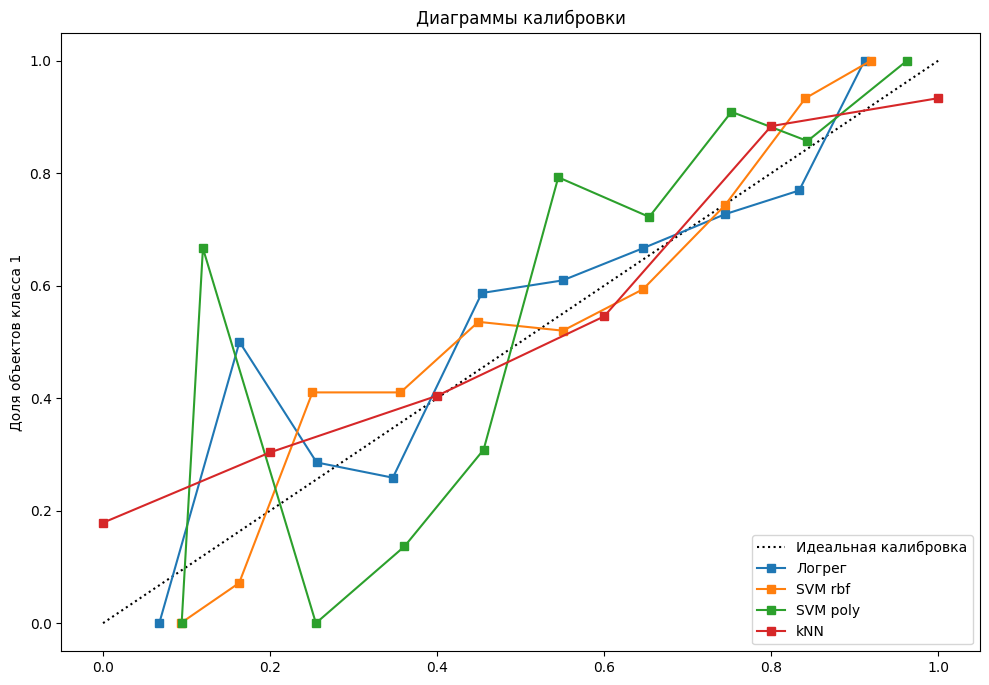

In [ ]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.plot([0, 1], [0, 1], "k:", label="Идеальная калибровка")

for clf, name in [
    (lr, "Логрег"),
    (svm_rbf, "SVM rbf"),
    (svm_poly, "SVM poly"),
    (knn, "kNN"),
]:
    clf.fit(X_train, y_train)
    prob_pos = clf.predict_proba(X_test)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, prob_pos, n_bins=10
    )
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % (name,))

ax1.set_ylabel("Доля объектов класса 1")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title("Диаграммы калибровки")
plt.tight_layout()
plt.show()

#### 1.2.3. ml-insights
А теперь взглянем на библиотеку ml-insights, в частности, ее функционал `plot_reliability_diagram`. Он более гибок и поддерживает:
- задание бинов "вручную" (в том числе неравномерных)
- отрисовка сопутствующей гистограммы
- перевод в logit шкалу для лучшего анализа калибрации экстремально больших и маленьких вероятностей

In [ ]:
#!pip install ml_insights

In [ ]:
import ml_insights as mli

In [ ]:
mli.plot_reliability_diagram?

Начнем со стандартной диаграммы

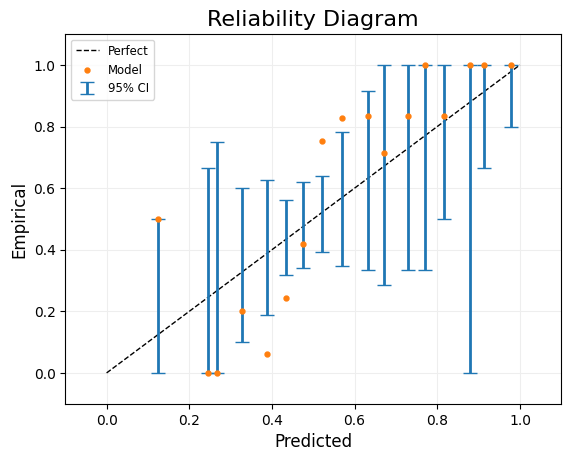

In [ ]:
rd = mli.plot_reliability_diagram(y_test, y_pred_proba);  # rd — reliability diagram

Добавление гистограммы

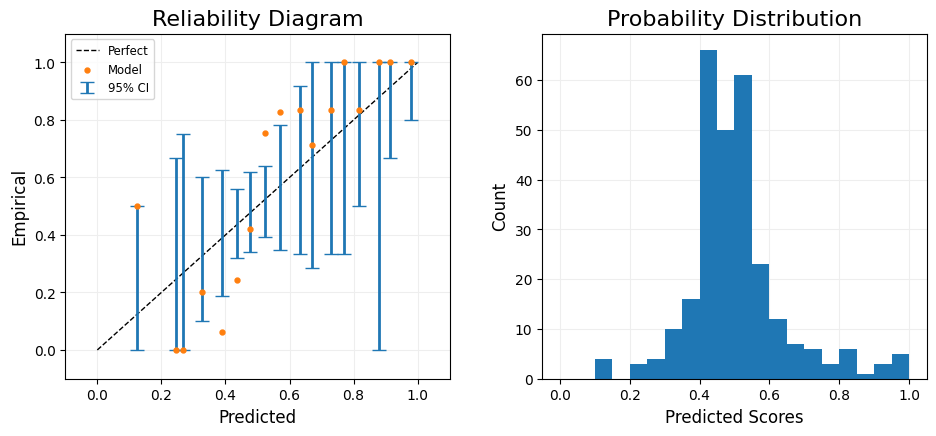

In [ ]:
plt.figure(figsize=(10, 5))
mli.plot_reliability_diagram(y_test, y_pred_proba, show_histogram=True);

Предположим, мы хотим измельчить бины, в которые попадает много объектов и, напротив, укрупнить разреженные.

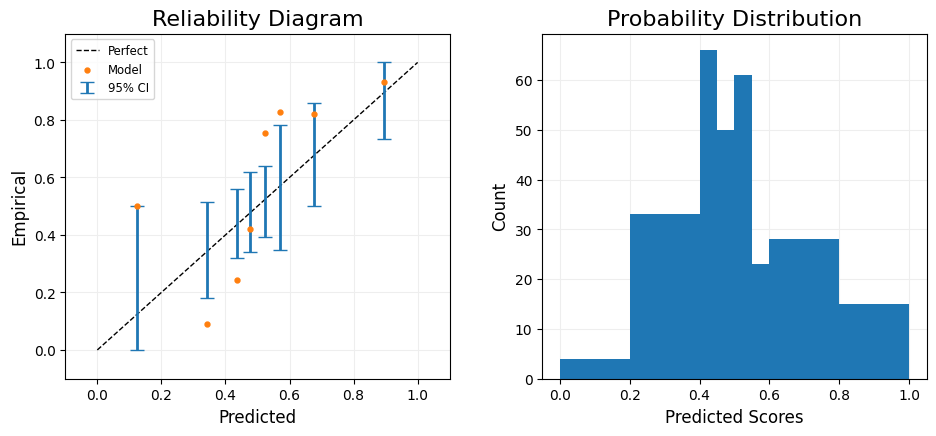

In [ ]:
plt.figure(figsize=(10, 5))
custom_bins = np.array([0.0, 0.2, 0.4, 0.45, 0.5, 0.55, 0.6, 0.8, 1.0])

mli.plot_reliability_diagram(
    y_test, y_pred_proba, bins=custom_bins, show_histogram=True
);

Возможно, наш классификатор странно ведет себя в окрестности нуля, но из такого представления однозначный вывод сделать нельзя. Чтобы взглянуть на экстремальные значения поближе, используем логит-шкалу. С помощью этого преобразования видимая область в окрестности нуля и единицы увеличится за счет видимой области окрестности значения 0.5.

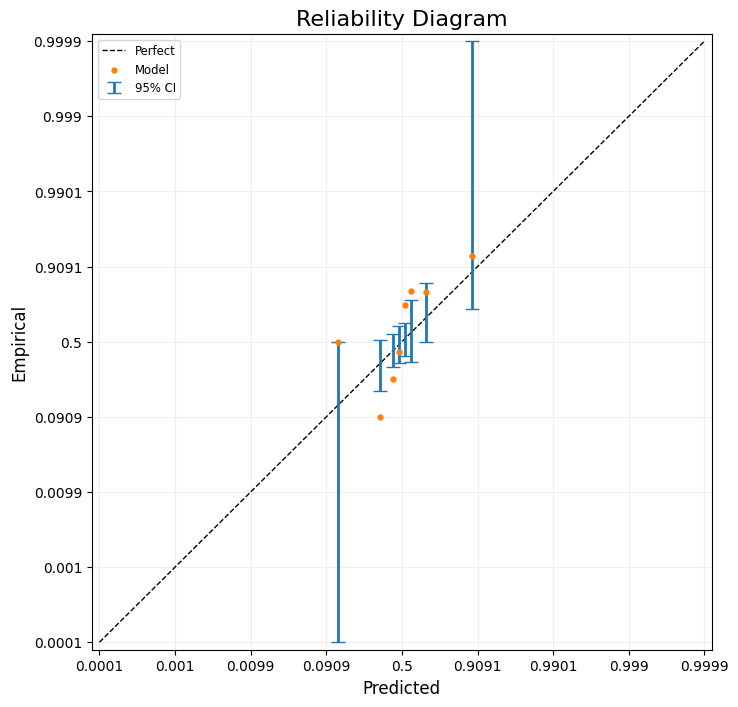

In [ ]:
plt.figure(figsize=(8, 8))
rd = mli.plot_reliability_diagram(
    y_test, y_pred_proba, scaling="logit", bins=custom_bins, marker="."
)

Функция вернула нам словарь `rd` — взглянем на ключи и возвращяемые по ним численные значения.

In [ ]:
rd.keys()

dict_keys(['pred_probs', 'emp_probs', 'bin_counts'])

In [ ]:
rd["pred_probs"], rd["emp_probs"], rd["bin_counts"]

(array([0.12428816, 0.34215571, 0.43466638, 0.47591126, 0.52215929,
        0.56971994, 0.67740507, 0.89339696]),
 array([0.5       , 0.09090909, 0.24242424, 0.42      , 0.75409836,
        0.82608696, 0.82142857, 0.93333333]),
 array([ 4., 33., 66., 50., 61., 23., 28., 15.]))

Задание: поэкспериментируйте с другими классификаторами

## 2. Калибровка<a class="anchor" id="chapter2"></a>
[К содержанию](#menu)

В общем виде, алгоритм калибровки предполагает, что мы создаем своего рода новую модель (назовем ее калибрационной), которая принимает на вход предсказания базовой модели, и возвращает откалиброванные вероятности. По сути, постановка задачи эквивалентна построению вероятностного классификатора над одним-единственным признаком.

Варианты использования данных:

Первый подход:
1. разделить датасет на обучающую, калибровочную и тестовую выборки (train, calibration, test)
2. обучить модель на обучающей выборке
3. обучить калибрационную модель на калибровочной выборке
4. оценить итоговую модель (базовую плюс калибрационную поверх нее) на тестовой выборке

Вместо этого можно обучить калибровочную модель на out-of-sample фолдах на кросс-валидации — второй подход.

Компромисс очевиден: первый подход проще, но в общем случае требует больше данных; второй занимает чуть больше времени, но более эффективен с точки зрения использования данных. В последующих примерах мы проиллюстрируем как один (на примере ml-insights), так и другой (на примере sklearn).

В этот раз мы начнем рассмотрение сразу с ml-insights; пример на основе sklearn оставим напоследок. Экспериментировать снова будем с полиномиальным SVM. Калибровку остальных моделей предлагается произвести в качестве упражнения.

### 2.1. Изотоническая регрессия

> Изотоническая регрессия — вид регрессии, в которой функциональная зависимость представлена в виде неубывающей (невозрастающей) кусочно-постоянной функции.

В некотором приближении можно сказать что мы минимизируем
$$ \sum_{i=1}^{n} (y_i - \hat{f}_i)^2 $$

с сохранением порядка выходов, где $y_i$ — i-ое целевое значение (т.е. по умолчанию 0 или 1), а $\hat{f}_i$ — i-ое выходное значение модели.

Из преимуществ: не накладывающий ограничений на подлежащую базовую модель метод, который при достаточном объеме данных демонстрирует хороший результат. Из недостатков: склонна к переобучению, что проявляется в "рваном" характере графика с дискретными, не вполне правдоподобными "прыжками"

<div>
<img src="https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/Isotonic_regression.svg" width="600"/>
</div>

In [ ]:
from sklearn.isotonic import IsotonicRegression

iso = IsotonicRegression(out_of_bounds="clip")

Разделим наши данные по-новой, выделив на этот раз калибровочную выборку; вдобавок заново обучим базовую модель

In [ ]:
X_train_, X_test, y_train_, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=7
)

X_train, X_calib, y_train, y_calib = train_test_split(
    X_train_, y_train_, test_size=0.3, random_state=7
)

svm = SVC(kernel="poly", degree=8, probability=True)
svm.fit(X_train, y_train)
y_test_pred_proba = svm.predict_proba(X_test)[:, 1]
y_calib_pred_proba = svm.predict_proba(X_calib)[:, 1]

In [ ]:
iso.fit(y_calib_pred_proba, y_calib)

IsotonicRegression(out_of_bounds='clip')

In [ ]:
y_calib_pred_proba_iso = iso.predict(y_calib_pred_proba)  # имена становятся длинноваты
y_test_pred_proba_iso = iso.predict(y_test_pred_proba)

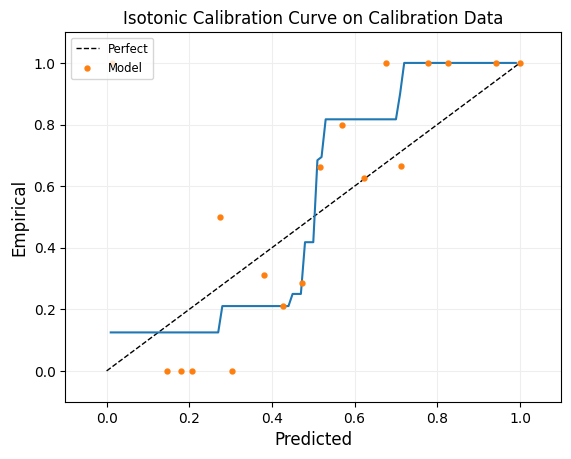

In [ ]:
mli.plot_reliability_diagram(y_calib, y_calib_pred_proba, error_bars=False)
tvec = np.linspace(0.01, 0.99, 99)
plt.plot(tvec, iso.predict(tvec), label="Isotonic")
plt.title("Isotonic Calibration Curve on Calibration Data");

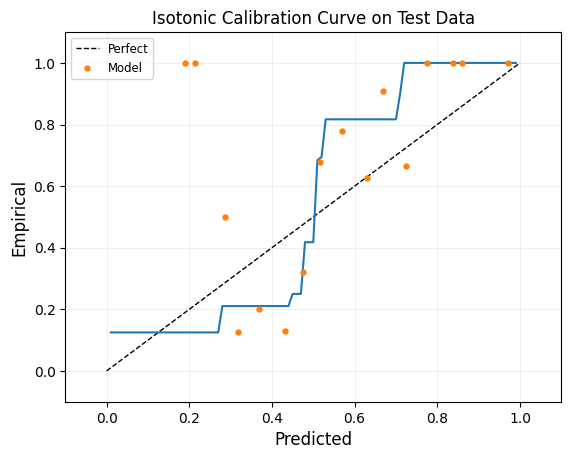

In [ ]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba, error_bars=False)
tvec = np.linspace(0.01, 0.99, 99)
plt.plot(tvec, iso.predict(tvec), label="Isotonic")
plt.title("Isotonic Calibration Curve on Test Data");

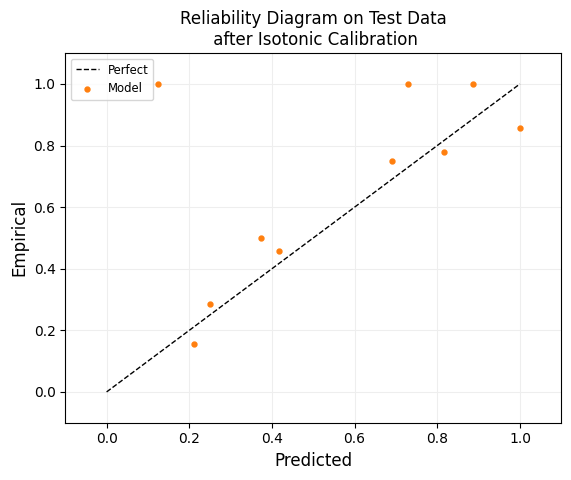

In [ ]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba_iso, error_bars=False)
plt.title("Reliability Diagram on Test Data\n after Isotonic Calibration");

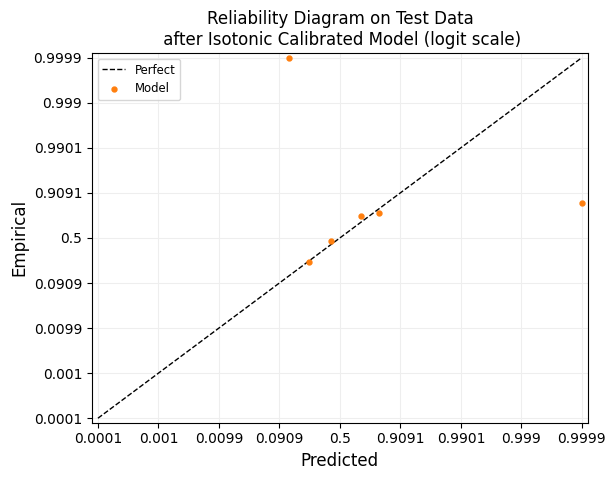

In [ ]:
custom_bins = np.array([0.0, 0.2, 0.4, 0.45, 0.5, 0.55, 0.6, 0.8, 1.0])
rd = mli.plot_reliability_diagram(
    y_test, y_test_pred_proba_iso, scaling="logit", bins=custom_bins, error_bars=False
)
plt.title(
    "Reliability Diagram on Test Data\n after Isotonic Calibrated Model (logit scale)"
);

### 2.2. Сигмоидальная регрессия Платта

Делается предпосылка о существовании отображения из класса логистических функций между скорами $z$ и истинными вероятностями $p$

$$\log\left(\frac{p}{1-p}\right) = \alpha + \beta f_i$$

Задача оптимизации:

$$ p(y_i = 1 | f_i) = \frac{1}{1 + \exp(-(\alpha + \beta f_i))} $$

где параметры $\alpha$ и $\beta$ определяются методом максимального правдоподобия, как в логистической регрессии.

Метод накладывает довольно сильные ограничения на класс исходных моделей: был придуман для SVM и его хорошая работа не гарантирована для остальных. Из плюсов: робастен на малых выборках.

In [ ]:
lr = LogisticRegression(C=1e5, solver="lbfgs")
lr.fit(y_calib_pred_proba.reshape(-1, 1), y_calib)

LogisticRegression(C=100000.0)

In [ ]:
y_calib_pred_proba_platt = lr.predict_proba(y_calib_pred_proba.reshape(-1, 1))[:, 1]
y_test_pred_proba_platt = lr.predict_proba(y_test_pred_proba.reshape(-1, 1))[:, 1]

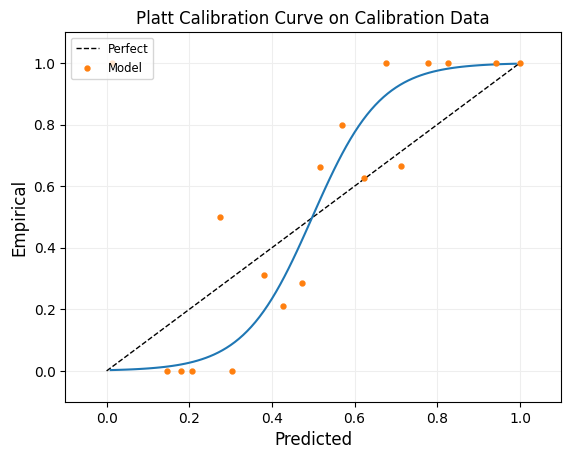

In [ ]:
mli.plot_reliability_diagram(y_calib, y_calib_pred_proba, error_bars=False)
tvec = np.linspace(0.01, 0.99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1, 1))[:, 1])
plt.title("Platt Calibration Curve on Calibration Data");

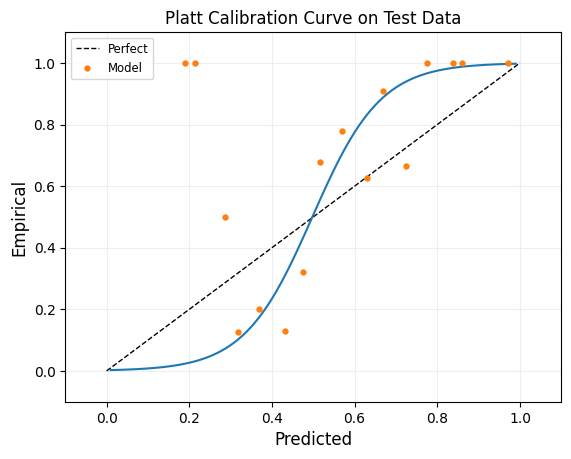

In [ ]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba, error_bars=False)
tvec = np.linspace(0.01, 0.99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1, 1))[:, 1])
plt.title("Platt Calibration Curve on Test Data");

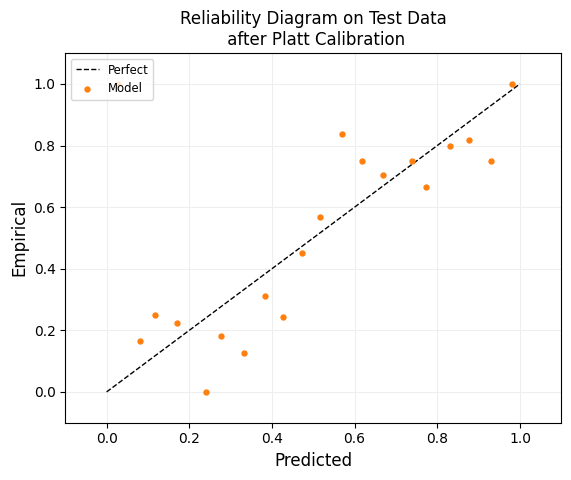

In [ ]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba_platt, error_bars=False)
plt.title("Reliability Diagram on Test Data\n after Platt Calibration");

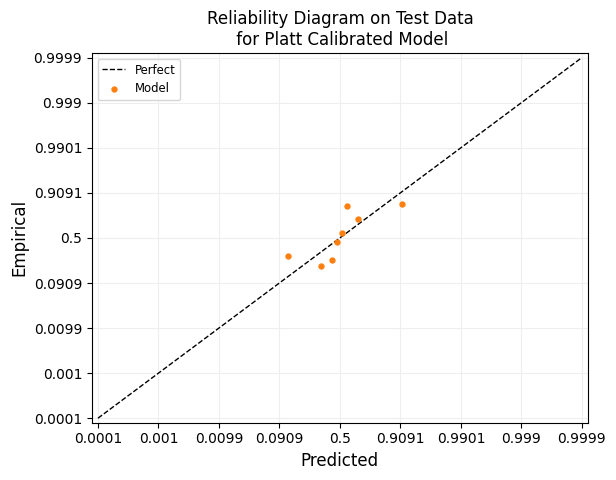

In [ ]:
custom_bins = np.array([0.0, 0.2, 0.4, 0.45, 0.5, 0.55, 0.6, 0.8, 1.0])
rd = mli.plot_reliability_diagram(
    y_test, y_test_pred_proba_platt, scaling="logit", bins=custom_bins, error_bars=False
)
plt.title("Reliability Diagram on Test Data\n for Platt Calibrated Model");

Благодаря логит-шкале можно увидеть, что калибрация не совсем справляется со своей задачей в случае экстремально малых и больших значений. Что, вообще говоря, неудивительно, поскольку ошибки в стиле "слишком близко к 0.5" являются более предпочтительными с точки зрения лог-лосса (лучше "недопредсказать" очень вероятные события и "перепредсказать" редкие).

In [ ]:
print(
    "Platt calibrated log_loss = {}".format(log_loss(y_test, y_test_pred_proba_platt))
)
print("Uncalibrated log_loss = {}".format(log_loss(y_test, y_test_pred_proba)))

Platt calibrated log_loss = 0.6098289820338854
Uncalibrated log_loss = 0.6348034034933454


Несмотря на это, мы добились некоторого улучшения в терминах лог-лосса.

### 2.3. Бета-калибрация

"A well-founded and easily implemented improvement on logistic calibration for binary classifiers."[2]

$p = \left(1+ 1 / \left( e^c \frac{z^a}{(1-z)^b} \right) \right)^{-1}$

В целом, бета-калибрацию можно считать улучшенной вариацией калибровки по Платту, а именно с добавлением следующих важных новшеств:
- Трехпараметрическое семейство (в отличие от двухпараметрического по Платту)
- Данное семейство функций *содержит* в себе идентичное отображение $y=x$, таким образом калибровка с его использованием по меньшей мере не ухудшит ситуацию в случае моделей, которые уже хорошо откалиброваны (чего нельзя сказать про предыдущие методы).

[2] Kull, M., Filho, T.S., Flach, P. (2017). Beta calibration: a well-founded and easily implemented improvement on logistic calibration for binary classifiers. Proceedings of the 20th International Conference on Artificial Intelligence and Statistics

In [ ]:
#!pip install betacal

In [ ]:
from betacal import BetaCalibration

In [ ]:
bc = BetaCalibration()
bc.fit(y_calib_pred_proba, y_calib)

BetaCalibration()

In [ ]:
y_calib_pred_proba_bc = bc.predict(y_calib_pred_proba)
y_test_pred_proba_bc = bc.predict(y_test_pred_proba)

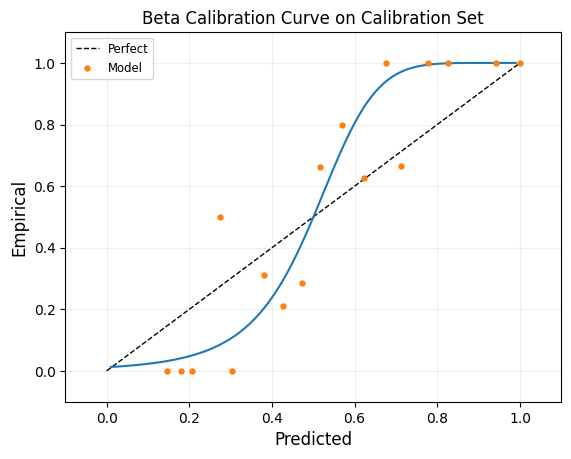

In [ ]:
mli.plot_reliability_diagram(y_calib, y_calib_pred_proba, error_bars=False)
tvec = np.linspace(0.01, 0.99, 99)
plt.plot(tvec, bc.predict(tvec))
plt.title("Beta Calibration Curve on Calibration Set");

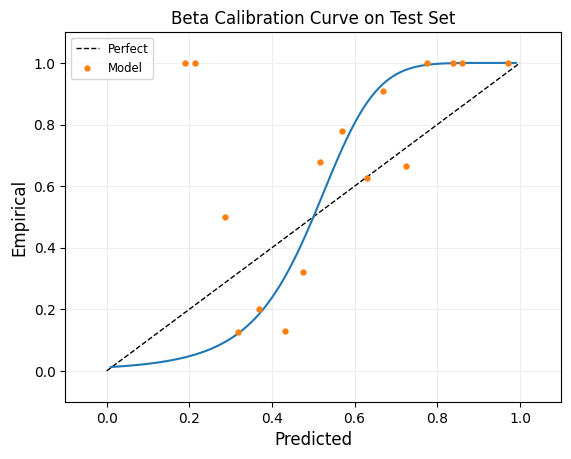

In [ ]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba, error_bars=False)
tvec = np.linspace(0.01, 0.99, 99)
plt.plot(tvec, bc.predict(tvec))
plt.title("Beta Calibration Curve on Test Set");

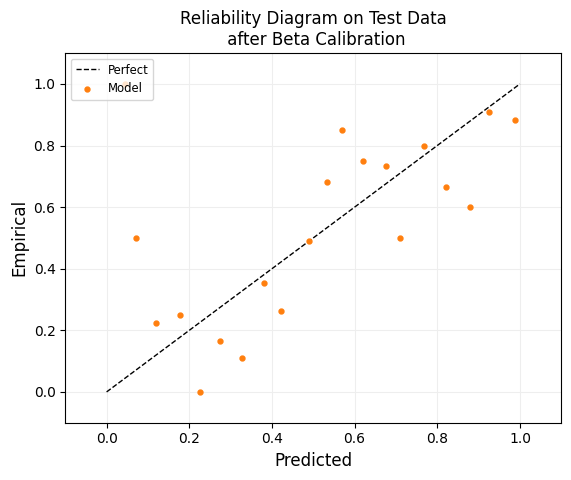

In [ ]:
mli.plot_reliability_diagram(y_test, y_test_pred_proba_bc, error_bars=False)
plt.title("Reliability Diagram on Test Data\n after Beta Calibration");

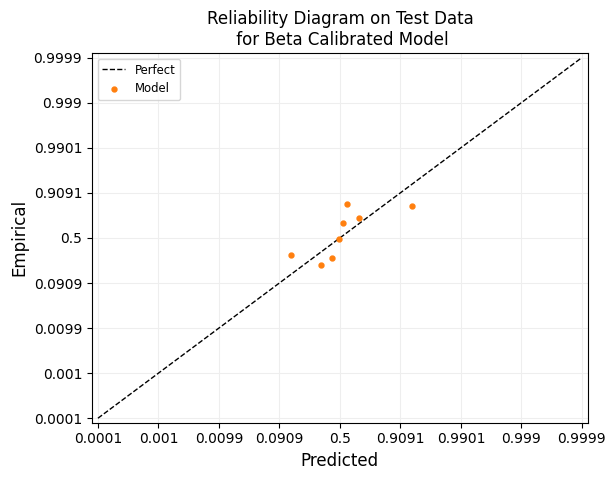

In [ ]:
custom_bins = np.array([0.0, 0.2, 0.4, 0.45, 0.5, 0.55, 0.6, 0.8, 1.0])
rd = mli.plot_reliability_diagram(
    y_test, y_test_pred_proba_bc, scaling="logit", bins=custom_bins, error_bars=False
)
plt.title("Reliability Diagram on Test Data\n for Beta Calibrated Model");

In [ ]:
print("Beta calibrated log_loss = {}".format(log_loss(y_test, y_test_pred_proba_bc)))
print(
    "Isotonic calibrated log_loss = {}".format(log_loss(y_test, y_test_pred_proba_iso))
)
print(
    "Platt calibrated log_loss = {}".format(log_loss(y_test, y_test_pred_proba_platt))
)
print("Uncalibrated log_loss = {}".format(log_loss(y_test, y_test_pred_proba)))

Beta calibrated log_loss = 0.6114017589629726
Isotonic calibrated log_loss = 0.8076506963986029
Platt calibrated log_loss = 0.6098289820338854
Uncalibrated log_loss = 0.6348034034933454


### 2.4. Sklearn (и калибрация на кросс-валидации)

А теперь посмотрим на то, как с данной задачей справится sklearn; посмотрим на изотоническую и Платт, при этом воспользуемся опцией калибровки на кросс-валидации.

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=11
)

base_estimator = svm_poly

calibrated_svm = CalibratedClassifierCV(
    estimator=base_estimator, method="isotonic" ### !!! base_estimator !!!
)

calibrated_svm.fit(X_train, y_train)
print(classification_report(y_test, calibrated_svm.predict(X_test)))

calibrated_platt_svm = CalibratedClassifierCV(
    estimator=base_estimator, method="sigmoid" ### !!! base_estimator !!!
)

calibrated_platt_svm.fit(X_train, y_train)
print(classification_report(y_test, calibrated_platt_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77       131
           1       0.79      0.80      0.80       149

    accuracy                           0.78       280
   macro avg       0.78      0.78      0.78       280
weighted avg       0.78      0.78      0.78       280

              precision    recall  f1-score   support

           0       0.71      0.80      0.75       131
           1       0.80      0.71      0.75       149

    accuracy                           0.75       280
   macro avg       0.76      0.76      0.75       280
weighted avg       0.76      0.75      0.75       280



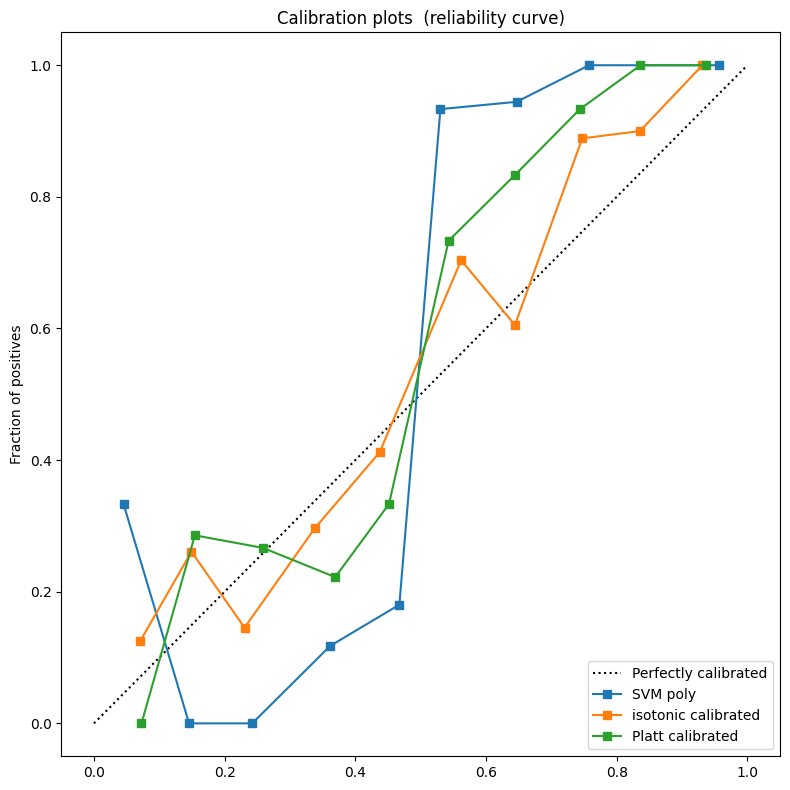

In [ ]:
plt.figure(figsize=(8, 8))

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

prob_pos = svm.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, prob_pos, n_bins=10
)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="SVM poly")

prob_pos = calibrated_svm.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, prob_pos, n_bins=10
)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="isotonic calibrated")

prob_pos = calibrated_platt_svm.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, prob_pos, n_bins=10
)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Platt calibrated")

plt.ylabel("Fraction of positives")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title("Calibration plots  (reliability curve)")
plt.tight_layout()
plt.show()